In [100]:
import pyvisa
import struct
import matplotlib.pyplot as plt

In [101]:
#Modify the following global variables according to the model
MODEL = "T3DSO2354A"
DSO_RSC = "TCPIP0::10.195.55.109::inst0::INSTR"

#The following code realizes the process of waveform reconstruction without slice
HORI_NUM = 10
CODE_PER_DIV ={MODEL:30}
BIT = {MODEL:8}

In [102]:
def main_desc(recv):
    WAVE_ARRAY_1 = recv[0x3c:0x3f+1]
    wave_array_count = recv[0x74:0x77+1]
    first_point = recv[0x84:0x87+1]
    sp = recv[0x88:0x8b+1]
    v_scale = recv[0x9c:0x9f+1]
    v_offset = recv[0xa0:0xa3+1]
    interval = recv[0xb0:0xb3+1]
    delay = recv[0xb4:0xbb+1]
    tdiv = recv[0x144:0x145+1]
    probe = recv[0x148:0x14b+1]
    tdiv_enum=[200e-12,500e-12,\
    1e-9,2e-9,5e-9,10e-9,20e-9,50e-9,100e-9,200e-9,500e-9,\
    1e-6,2e-6,5e-6,10e-6,20e-6,50e-6,100e-6,200e-6,500e-6,\
    1e-3,2e-3,5e-3,10e-3,20e-3,50e-3,100e-3,200e-3,500e-3,\
    1,2,5,10,20,50,100,200,500,1000]
    probe_enum=[0.1,0.2,0.5,1,2,5,10,20,50,100,200,500,1e3,2e3,5e3,10e3,\
    "CUSTA","CUSTB","CUSTC","CUSTD"]

    data_bytes = struct.unpack('i',WAVE_ARRAY_1)[0]
    point_num = struct.unpack('i',wave_array_count)[0]
    fp = struct.unpack('i',first_point)[0]
    sp = struct.unpack('i',sp)[0]
    interval = struct.unpack('f',interval)[0]
    delay = struct.unpack('d',delay)[0]
    tdiv_index = struct.unpack('h',tdiv)[0]
    probe_index = struct.unpack('i',probe)[0]

    if probe_index > 15:
        probe = struct.unpack('f',probe)[0]
    else:
        probe = probe_enum[probe_index]
        
    vdiv = struct.unpack('f',v_scale)[0]*probe
    offset = struct.unpack('f',v_offset)[0]*probe
    tdiv = tdiv_enum[tdiv_index]
    
    return vdiv,offset,interval,delay,tdiv


Lecory,T3DSO2502A,T0101C21490989,5.0.1.3.9R6

200


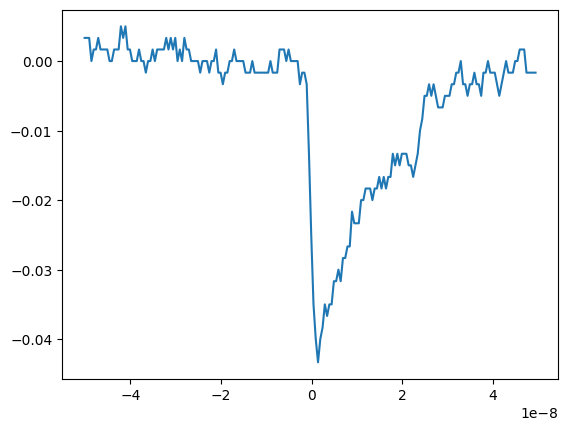

In [103]:
_rm = pyvisa.ResourceManager('@py')
dso = _rm.open_resource(DSO_RSC)
print(dso.query("*IDN?"))

dso.timeout = 30000 #default value is 2000(2s)
dso.chunk_size = 20*1024*1024 #default value is 20*1024(20k bytes)
dso.write("WAV:SOUR C1")
dso.write("WAV:PREamble?")
recv = dso.read_raw()[16:]
vdiv,ofst,interval,trdl,tdiv = main_desc(recv)

if BIT[MODEL] > 8:
    dso.write(":WAVeform:WIDTh WORD")
dso.write("WAV:DATA?")
recv = list(dso.read_raw())[16:]
recv.pop()
recv.pop()
volt_value = []
convert_data = []

if BIT[MODEL] > 8:
    for i in range(0, int(len(recv) / 2)):
        data_16bit = recv[2 * i] + recv[2 * i + 1] * 256
        data = data_16bit >> (16-BIT[MODEL])
        convert_data.append(data)
else:
    convert_data = recv

for data in convert_data:
    if data > pow(2,BIT[MODEL]-1)-1:#12bit:>2047,8bit:>127
        data = data - pow(2,BIT[MODEL])
    else:
        pass
    volt_value.append(data)
    
print(len(volt_value))
time_value = []
for idx in range(0,len(volt_value)):
    volt_value[idx] = volt_value[idx]/CODE_PER_DIV[MODEL]*float(vdiv)-float(ofst)
    time_data = -float(trdl)-(float(tdiv)*HORI_NUM/2)+idx*interval
    time_value.append(time_data)

plt.plot(time_value,volt_value)